<h1><center> Abstract </center></h1>

<p><div style = "text-align: justify; font-size: 14px">The main topic of this project was addressing, to varying degrees, questions of multicollinearity, autocorrelation, normality etc.</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Important note</b>: should you want to maximise predictive accuracy, you have to opt for more sophisticated algorithms. Nevertheless, linear regression is still valuable when it comes to exploring relationships, making statistical inferences and interpreting results of your research. Also, it goes without saying that using $R$ for anything beyond basic statistics is considerably more handy since there are so many scientific libraries built specifically for tackling stat-related issues</div></p>

<h1><center> I. Preparation </center></h1>

In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import normal_ad
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.graphics import tsaplots
import matplotlib.collections
from statsmodels.stats.diagnostic  import acorr_ljungbox
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
    
warnings.simplefilter(action = 'ignore', category = FutureWarning)

sns.set_theme(rc = {'grid.linewidth': 0.6, 'grid.color': 'white',
                    'axes.linewidth': 2, 'axes.facecolor': '#ECECEC', 
                    'axes.labelcolor': '#000000',
                    'figure.facecolor': 'white',
                    'xtick.color': '#000000', 'ytick.color': '#000000'})


def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>')

## 1. Data <a class="anchor" id = "I_1"></a>

<p><div style = "text-align: justify; font-size: 14px">The dataset used is the <a href="https://www.kaggle.com/datasets/hellbuoy/car-price-prediction">car price dataset</a>, which is designed for regression-like tasks.</div></p>

In [3]:
df = pd.read_csv('./0_Data/car_prices.csv')

## 2. Determining numeric and categorical features

In [12]:
Cat_vars = []
Num_vars = []

for col in list(df.columns):
    if ((df[col].dtype == 'float64') or (df[col].dtype == 'int64')) and (df[col].nunique() > 10):
        Num_vars.append(col)
    else:
        Cat_vars.append(col)

Num_vars.remove('car_ID')
Num_vars.remove('price')
Cat_vars.remove('CarName')

<h1><center> II. Quick EDA </center></h1>

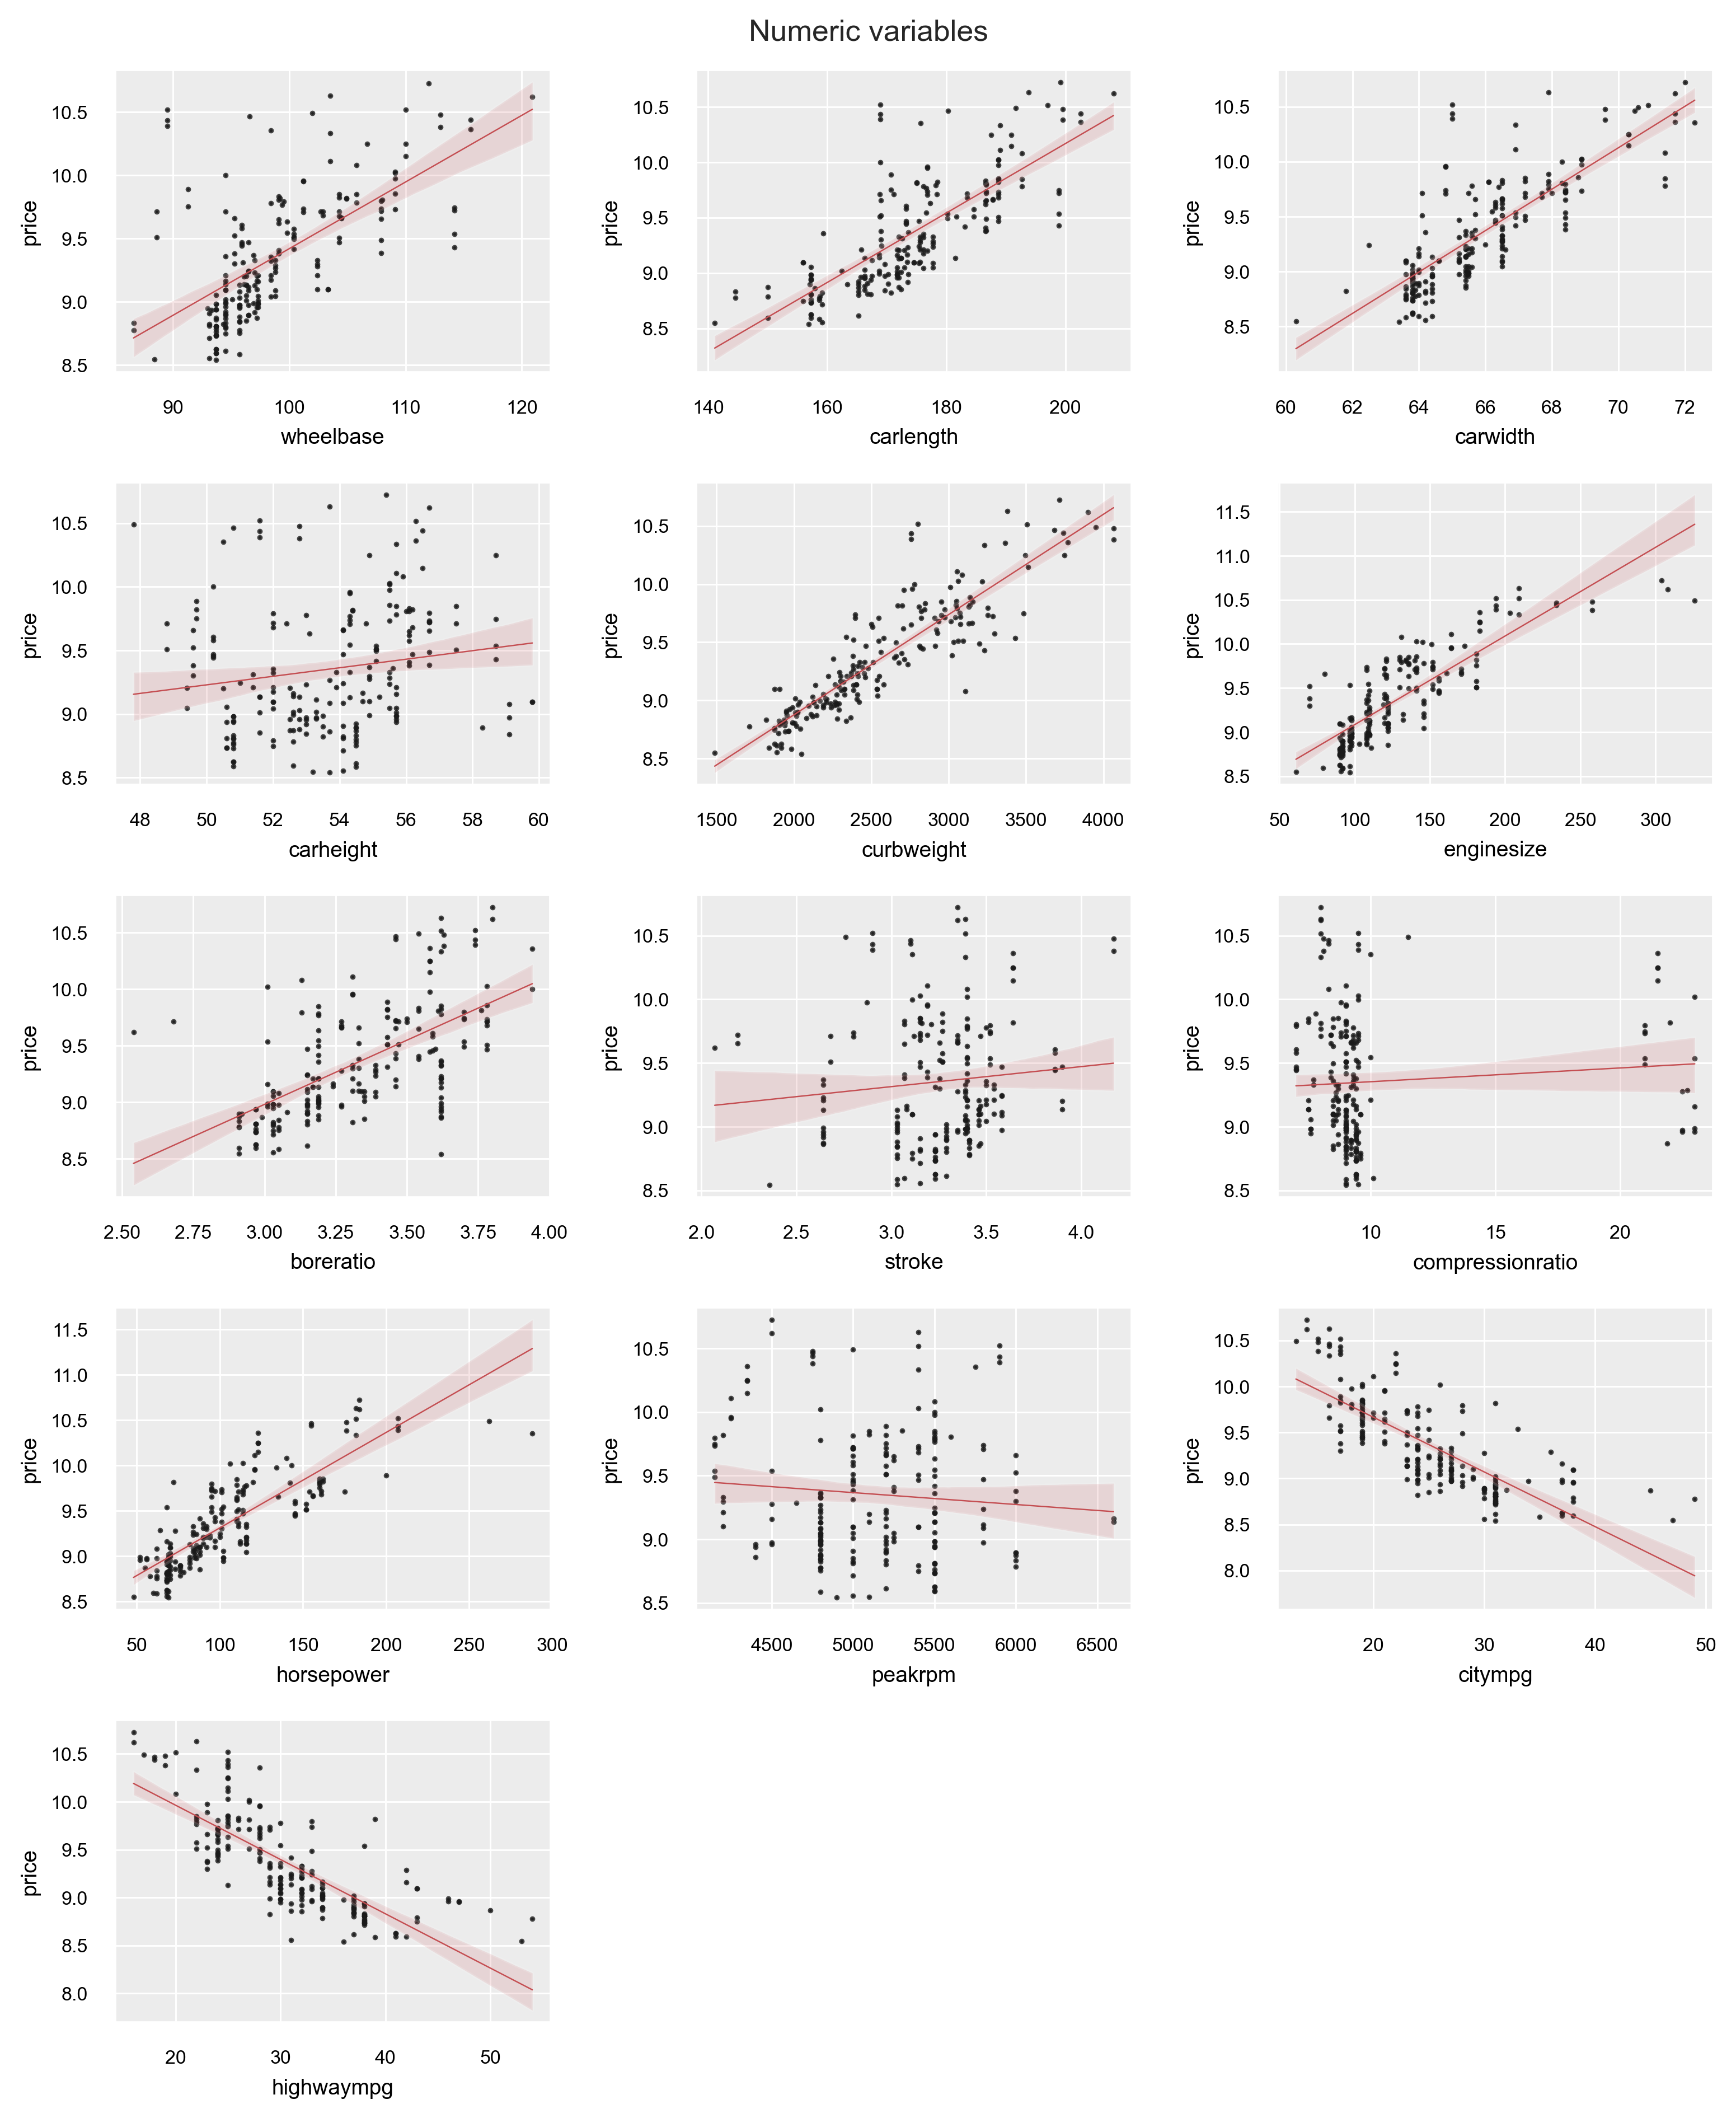

In [73]:
with plt.rc_context(rc={'figure.dpi': 350, 'axes.labelsize': 8, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7}): 

    fig, ax = plt.subplots(5, 3, figsize=(9, 11))

    for idx, (column, axes) in list(enumerate(zip(Num_vars, ax.flatten()))):
        sns.regplot(ax=axes, x=df[column], y=np.log(df['price']),
                    scatter_kws={'s': 1, 'color': 'k'}, 
                    line_kws={'lw': 0.5, 'color': 'r'})
    
    else:
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    fig.suptitle('Numeric variables', fontsize=11)
    plt.tight_layout(pad=1)
    plt.show()

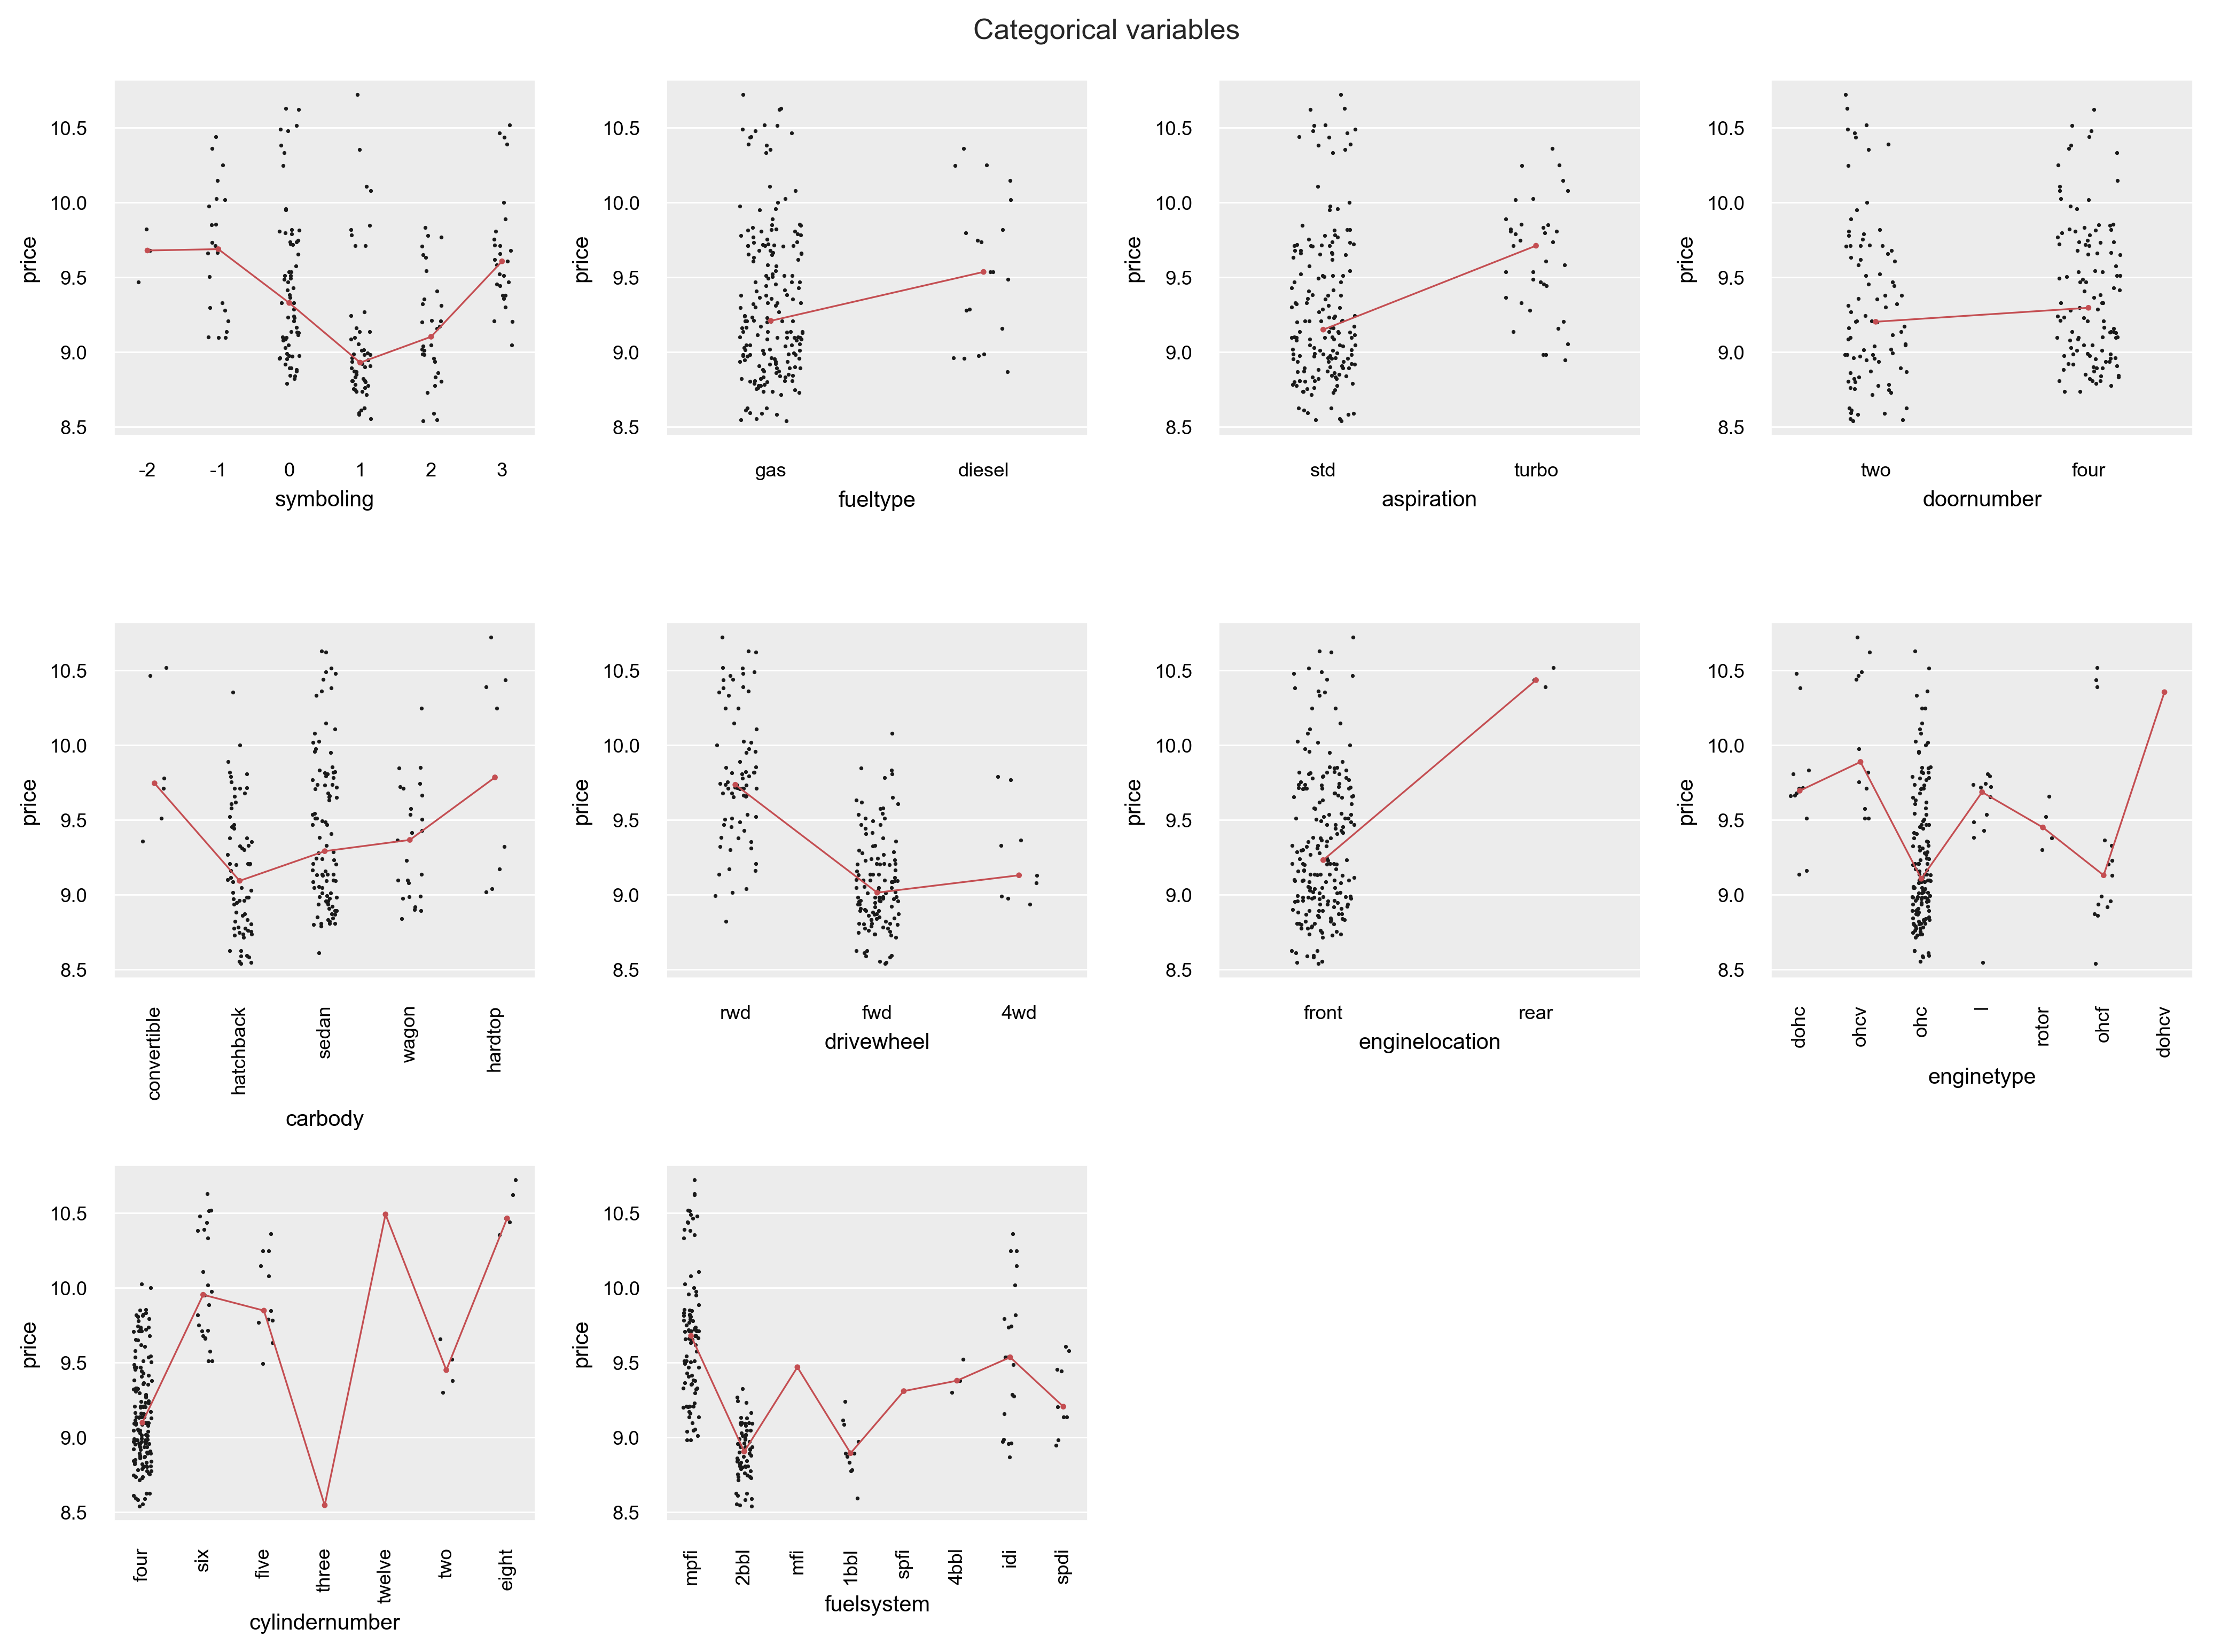

In [16]:
with plt.rc_context(rc={'figure.dpi': 350, 'axes.labelsize': 8.5, 
                        'xtick.labelsize': 7.5, 'ytick.labelsize': 7.5}): 

    fig, ax = plt.subplots(3, 4, figsize=(12, 9))

    for idx, (column, axes) in list(enumerate(zip(Cat_vars, ax.flatten()))):
        plt.setp(axes.collections, alpha=0.1)
    
        sns.stripplot(ax=axes, x=df[column], 
                      y=np.log(df['price']),
                      color='k', s=1.5, alpha=1,
                      jitter=0.15)
        
        sns.pointplot(ax=axes, x=df[column],
                      y=np.log(df['price']),
                      color='r', scale=0.25,
                      estimator=np.median,  # ci='sd', capsize=0.05,
                      join=True, errwidth=0)
    
        plt.setp(axes.lines, zorder=100)
        plt.setp(axes.collections, zorder=100)
        
        if (df[column].dtypes == 'O') & (df[column].nunique() > 4):
            plt.setp(axes.get_xticklabels(), rotation=90)
    
    else:
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    fig.suptitle('Categorical variables', fontsize=11)
    plt.tight_layout()
    plt.show()

<h1><center> III. Building models </center></h1>

<p><div style = "text-align: justify; font-size: 14px">Since the purpose of this project was not to determine the most important variables but rather to showcase some hopefully useful techniques, regressors were picked arbitrarily.</div></p>

In [29]:
X = pd.concat([pd.get_dummies(df[['drivewheel', 'aspiration']].astype(object), 
                              drop_first=True,  dtype='float'), 
              df[['horsepower', 'wheelbase']]],
              axis=1, join='outer', ignore_index=False)

Y = df[['price']]

In [30]:
model_1 = sm.OLS(endog=np.log(Y), exog=sm.add_constant(X))
model_1_fit = model_1.fit()
model_1_pred = model_1_fit.predict()

print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     193.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.86e-74
Time:                        19:32:56   Log-Likelihood:                 31.598
No. Observations:                 205   AIC:                            -51.20
Df Residuals:                     199   BIC:                            -31.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8585      0.289  

## 1. Multicollinearity <a class="anchor" id = "III_1"></a>

<p><div style = "text-align: justify; font-size: 14px">After the first model was built, the following warning appeared:</div></p>

```
[2] The condition number is large, 2.89e+03. This might indicate that there are strong multicollinearity or other numerical problems.
```

<p><div style = "text-align: justify; font-size: 14px">When we use regression for interpreting results, we need to address multicollinearity, otherwise our coefficients may be unstable, despite the fact that the efficacy of the model itself is not affected. However, it is important to remember that not every case of multicollinearity results in the aforementioned issues.</div></p>

### 1.1 Standard errors and $VIF$

<p><div style = "text-align: justify; font-size: 14px">Before removing collinear variables, analyse their standard errors and explore what happens with coefficients if you temporarily remove one of such regressors from the model. For instance, both <span style="color:#0049d1">horsepower</span> and <span style="color:#0049d1">wheelbase</span> were positively correlated with the target variable and each other. Nonetheless, their standard errors were not inflated. One can see it by comparing $\widehat{se}(\hat{β}_i)$ to $\hat{β}_i$:</div></p>

$$Horsepower: \frac{\widehat{se}(\hat{β}_5)}{\hat{β}_5} = \frac{0.000468}{0.007775}×100 = 6.016\text{%}$$

$$Wheelbase: \frac{\widehat{se}(\hat{β}_6)}{\hat{β}_6} = \frac{0.002908}{0.027494}×100 = 10.576\text{%}$$

<p><div style = "text-align: justify; font-size: 14px">Following that, 2 models were created and compared: with <span style="color:#0049d1">horsepower</span> but without <span style="color:#0049d1">wheelbase</span> and vice versa.</div></p>

In [31]:
model_1_a = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X.drop('horsepower', axis = 1)))
model_1_a_fit = model_1_a.fit()

model_1_b = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X.drop('wheelbase', axis = 1)))
model_1_b_fit = model_1_b.fit()

In [32]:
pd.DataFrame([model_1_fit.bse, model_1_fit.params, (model_1_fit.bse / model_1_fit.params)*100,
              model_1_a_fit.bse, model_1_a_fit.params, (model_1_a_fit.bse / model_1_a_fit.params)*100,
              model_1_b_fit.bse, model_1_b_fit.params, (model_1_b_fit.bse / model_1_b_fit.params)*100],
              index = ['SE', 'Coeff', 'SE / Coeff, %', 'SE', 'Coeff', 'SE / Coeff, %', 
                       'SE', 'Coeff', 'SE / Coeff, %']).iloc[0:, 4:]

,horsepower,wheelbase
SE,0.000468,0.002908
Coeff,0.007775,0.027494
"SE / Coeff, %",6.016465,10.575984
SE,NaN,0.004478
Coeff,NaN,0.029673
"SE / Coeff, %",NaN,15.090172
SE,0.000561,NaN
Coeff,0.007974,NaN
"SE / Coeff, %",7.036922,NaN


<p><div style = "text-align: justify; font-size: 14px">In both cases, $\widehat{se}(\hat{β}_i)$ and $\hat{β}_i$ did not change drastically, which was definitely a good sign. One can also calculate $VIF$ so as to get a better idea of how collinear predictors affect a model. Note, you should analyse $VIF$ values only for continuous variables.</div></p>

In [36]:
X_VIF = model_1_fit.model.exog
VIF = list((variance_inflation_factor(X_VIF, x) for x in range(X_VIF.shape[1])))

df_VIF = pd.DataFrame(VIF, columns = ['VIF'], index = list(model_1_fit.params.index))

df_VIF.iloc[4:, 0:].round(4)

,VIF
horsepower,1.5751
wheelbase,1.4114


<p><div style = "text-align: justify; font-size: 14px">Values were fairly low, supporting the idea of an insignificant multicollinearity effect.</div></p>

### 1.2 Eigenvalues and eigenvectors

<p><div style = "text-align: justify; font-size: 14px">We can use eigenvalues and eigenvectors to determine the presence of multicollinearity. First, we should explore eigenvalues, paying attention to low values as they show us which principal components explain the least amount of variance and, as a result, show collinearity. After that, we have to analyse elements of eigenvectors, figuring out what variables are collinear.</div></p>

<p><div style = "text-align: justify; font-size: 14px"> <b>Source</b>: [<a href="https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels">1</a>].</div></p>

<p><div style = "text-align: justify; font-size: 14px">To make it more evident, a second model containing only continuous predictors was built:</div></p>

In [37]:
X_2 = df[['carwidth', 'carlength', 'citympg', 'boreratio', 'stroke']]

model_2 = sm.OLS(endog = np.log(Y), exog = sm.add_constant(X_2))
model_2_fit = model_2.fit()

print(model_2_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.23e-60
Time:                        19:35:37   Log-Likelihood:                -1.3079
No. Observations:                 205   AIC:                             14.62
Df Residuals:                     199   BIC:                             34.55
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2803      0.799      2.854      0.0

In [41]:
def PCA(df, Vars_list):
    
    # Scaling data
    
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(df.filter(Vars_list)), 
                               columns = df.filter(Vars_list).columns)
    
    # Calculating the correlation matrix
    
    Corr_m = data_scaled.corr()
    
    # Getting eigenvalues and eigenvectors
    
    values, vectors = np.linalg.eig(Corr_m)
    
    return values, vectors

In [48]:
Results = PCA(X_2, list(X_2.columns))

A = pd.DataFrame({'Eigenvalue': Results[0]},
                 index = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(3)

B = pd.DataFrame({'Variance, %': Results[0] / sum(Results[0])*100},
                 index = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(1)

C = pd.DataFrame(Results[1], index = list(X_2.columns),
                 columns = ['PC ' + str(X) for X in range(1, len(Results[0]) + 1)]).round(2)

In [49]:
multi_table([A, B, C])

,Eigenvalue
PC 1,2.973
PC 2,1.041
PC 3,0.155
PC 4,0.447
PC 5,0.383
,"Variance, %"
PC 1,59.5
PC 2,20.8
PC 3,3.1
PC 4,8.9


<p><div style = "text-align: justify; font-size: 14px">PC 3 had the lowest eigenvalue, explaining around 3% of the total variance in data. Unsurprisingly, the largest absolute values of the eigenvector's elements were 0.68 and 0.73. These two values represented <span style="color:#0049d1">carwidth</span> and <span style="color:#0049d1">carlength</span> respectively.</div></p>

### 1.3 Using $GVIF$ for mixed data

<p><div style = "text-align: justify; font-size: 14px">If a model contains both continuous and categorical (dummy-encoded) regressors, you may be interested in exploring whether categorical variables cause multicollinearity. In this case, $GVIF$ can be of great use. To make $GVIF$ comparable, it incorporates degrees of freedom. For instance, if your categorical variable can be encoded via 4 dummy variables, it has 4 – 1 = 3 degrees of freedom: $GVIF^{(0.5Df)} = GVIF^{(0.5*3)}$. Thus, $GVIF$ for continuous predictors is the same as $VIF$ (since each of them has only 1 degree of freedom). Finally, should you want to make $GVIF^{(0.5Df)}$ comparable to $VIF$ in order to apply some frequently used rules of thumb, you will need to square $GVIF^{(0.5Df)}$.</div></p>

<p><div style = "text-align: justify; font-size: 14px"> <b>Source</b>: [<a href="https://www.jstor.org/stable/2290467">1</a>, <a href="https://stats.stackexchange.com/questions/70679/which-variance-inflation-factor-should-i-be-using-textgvif-or-textgvif/96584#96584">2</a>, <a href="http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-5-Multiple-collinearity.html">3</a>].</div></p>

<p><div style = "text-align: justify; font-size: 14px">Unfortunately, $GVIF$ has not been implemented in Python yet, so manual calculations were made (for <span style="color:#0049d1">drivewheel</span>).</div></p>

In [50]:
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     193.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.86e-74
Time:                        19:40:17   Log-Likelihood:                 31.598
No. Observations:                 205   AIC:                            -51.20
Df Residuals:                     199   BIC:                            -31.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8585      0.289  

In [51]:
det_1 = np.linalg.det(X.iloc[0:, 0:2].corr())
det_2 = np.linalg.det(X.iloc[0:, 2:].corr())
det_3 = np.linalg.det(X.corr())

GVIF = det_1 * det_2 / det_3

GVIF_all = pd.DataFrame({'GVIF': [GVIF],
                         'GVIF^(1/2Df)': [np.power(GVIF, 1 / (2 * len(X.iloc[0:, 0:2].columns)))]},
                        index = ['drivewheel'])

GVIF_all.round(3)

,GVIF,GVIF^(1/2Df)
drivewheel,1.805,1.159


<p><div style = "text-align: justify; font-size: 14px">In $R$ this procedure can be done with ease. These were the results for all the regressors:</div></p>

```
vif(lm_model)

               GVIF Df  GVIF^(1/(2*Df))
drivewheel 1.805168  2        1.159123
aspiration 1.127569  1        1.061871
horsepower 1.575096  1        1.255028
wheelbase  1.411371  1        1.188012
```

## 2. Residual analysis <a class="anchor" id = "III_2"></a>

### 2.1 Assumptions overview. Theory

<p><div style = "text-align: justify; font-size: 14px">We consider the population regression model: $Y = f(x) + ε$, where $f(x)$ is $E(Y|x)$, and it depends on parameters $β_1,β_2,…,β_k$. Thus, a sample regression model is $Y = \hat{f}(x) + \hat{ε}$, and it depends on $\hat{β}_1,\hat{β}_2,…,\hat{β}_k$.</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Required assumptions (fixed $X$ – experimental studies)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 14px">1) $\hat{β}_i$ is unbiased if:</div></p>

* <div style = "font-size: 14px">$E(ε) = 0$.</div>

<p><div style = "text-align: justify; font-size: 14px">2) $\hat{β}_i$ is the BLUE (best linear unbiased estimator) if:</div></p>
    
* <div style = "font-size: 14px">$E(ε) = 0$;</div>
* <div style = "font-size: 14px">$Var(ε) = σ^2 < ∞$;</div> 
* <div style = "font-size: 14px">$Cov(ε_i,ε_j) = 0, i ≠ j$.</div> 
    
<p><div style = "text-align: justify; font-size: 14px">3) We can test hypothesis and create confidence intervals if:</div></p>

* <div style = "font-size: 14px">$ε$ ~ $N(0,σ^2)$. In other words, $Y$ ~ $N(f(x),σ^2)$.</div>

<p><div style = "text-align: justify; font-size: 14px"><b>Required assumptions (random $X$ – observational studies)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 14px">1) $\hat{β}_i$ is unbiased if:</div></p>

* <div style = "font-size: 14px">$E(ε|X) = 0$.</div>

<p><div style = "text-align: justify; font-size: 14px">2) $\hat{β}_i$ is the BLUE (best linear unbiased estimator) if:</div></p>
    
* <div style = "font-size: 14px">$E(ε|X) = 0$;</div>
* <div style = "font-size: 14px">$Var(ε|X) = σ^2 < ∞$;</div> 
* <div style = "font-size: 14px">$Cov(ε_i,ε_j|X) = 0, i ≠ j$.</div> 
    
<p><div style = "text-align: justify; font-size: 14px">3) We can test hypothesis and create confidence intervals if:</div></p>

* <div style = "font-size: 14px">$ε$ ~ $N(0,σ^2)$. In other words, $Y$ ~ $N(f(x),σ^2)$.</div>

<p><div style = "text-align: justify; font-size: 14px"> <b>Some insightful comments on this topic</b>: [<a href="https://stats.stackexchange.com/questions/246047/independent-variable-random-variable">1</a>, <a href="https://towardsdatascience.com/ols-linear-regression-gauss-markov-blue-and-understanding-the-math-453d7cc630a5">2</a>].</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Some other important requirements (in practice)</b>:</div></p>

<p><div style = "text-align: justify; font-size: 14px">1) While exploring $Cov(\hat{ε}_i,X)$ can allow us to understand better how a particular regressor behaves in our model, $Cov(\hat{ε}_i,\hat{f}(x))$ reveals whether a meaningful relationship between $\hat{ε}_i$ and $\hat{f}(x)$ exists. The latter is frequently caused by a lack of important regressor(s):</div> </p>

* <div style = "font-size: 14px">$Cov(\hat{ε}_i,X) = 0$ and $Cov(\hat{ε}_i,\hat{f}(x)) = 0$.</div>

<p><div style = "text-align: justify; font-size: 14px">2) This property is true by definition. However, a strong correlation is not a good sign because it means that your model does not include important independent variables:</div></p>

* <div style = "font-size: 14px">$Cov(\hat{ε}_i,y_i) ≠ 0$ but not too strong.</div>

<p><div style = "text-align: justify; font-size: 14px"> <b>Some insightful comments on this topic</b>: [<a href="https://stats.stackexchange.com/questions/155587/residual-plots-why-plot-versus-fitted-values-not-observed-y-values">1</a>, <a href="https://stats.stackexchange.com/questions/476372/plotting-residuals-vs-fitted-values-or-vs-independent-variables">2</a>, <a href="https://stats.stackexchange.com/questions/406478/high-correlation-between-residuals-and-dependent-variable">3</a>].</div></p>

### 2.2 Heteroskedasticity and normality. Practice

<p><div style = "text-align: justify; font-size: 14px">One of the best ways to make sure that these assumptions hold is to produce some insightful graphs:</div></p>

In [53]:
df['log price'] = np.log(df['price'])
model_1_results = pd.DataFrame({'log price fitted': model_1_pred, 'residuals': model_1_fit.resid})

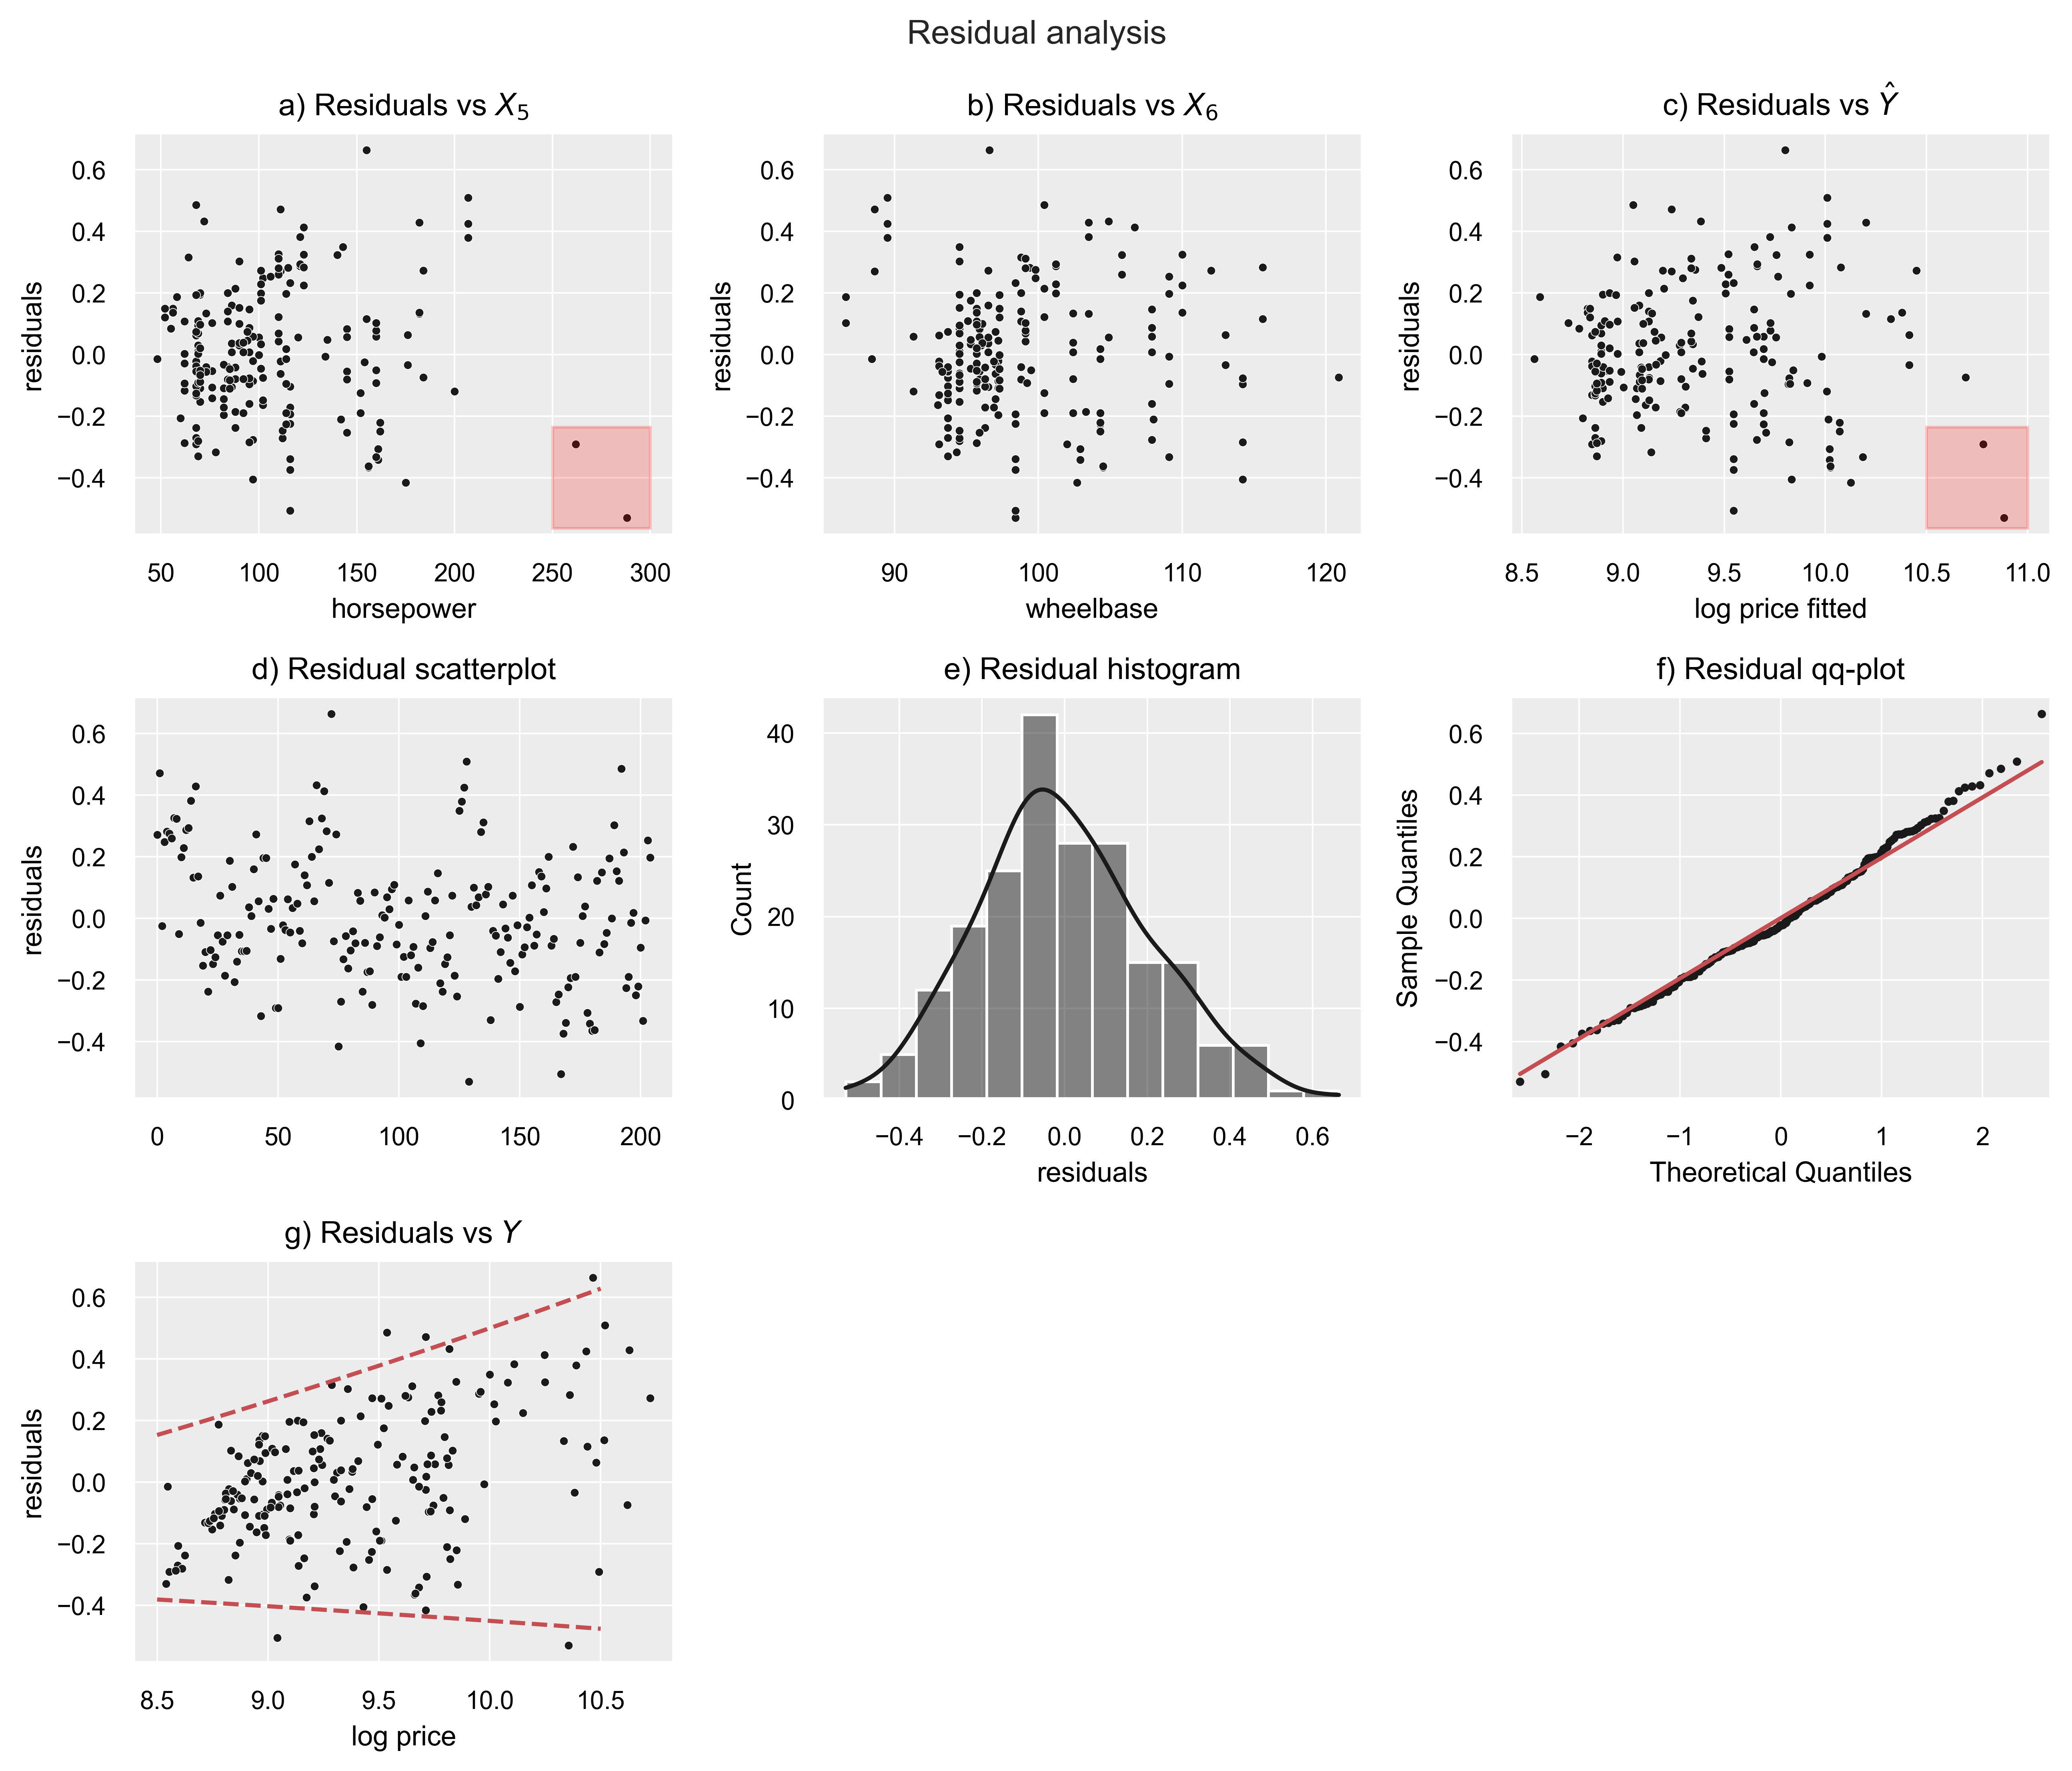

In [56]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 10, 
                        'xtick.labelsize': 9, 'ytick.labelsize': 9}): 

    fig, ax = plt.subplots(3, 3, figsize=(10.5, 9))
    ax_flat = ax.flatten()
    
    # Plots № 1 - 3
    
    sns.scatterplot(ax=ax_flat[0], y=model_1_results['residuals'], x=df['horsepower'], 
                    s=9.5, color='k')
    
    ax_flat[0].set_title('a) Residuals vs $X_5$', fontsize=11, color='black')
    ax_flat[0].axvspan(xmin=250, xmax=300, 
                       ymin=0.02, ymax=0.27, 
                       alpha=0.2, color='red')
    
    sns.scatterplot(ax=ax_flat[1], y=model_1_results['residuals'], x=df['wheelbase'],
                    s=9.5, color='k')
    
    ax_flat[1].set_title('b) Residuals vs $X_6$', fontsize=11, color='black')

    sns.scatterplot(ax=ax_flat[2], y=model_1_results['residuals'], 
                    x=model_1_results['log price fitted'], s=9.5, color='k')
    
    ax_flat[2].set_title('c) Residuals vs $\hat{Y}$', fontsize=11, color='black')
    ax_flat[2].axvspan(xmin=10.5, xmax=11, 
                       ymin=0.02, ymax=0.27, 
                       alpha=0.2, color='red')
    
    # Plots № 3 - 6
    
    sns.scatterplot(ax=ax_flat[3], y=model_1_results['residuals'], x=Y.index,
                    s=9.5, color='k')
    
    ax_flat[3].set_title('d) Residual scatterplot', fontsize=11, color='black')
    
    sns.histplot(ax=ax_flat[4], x=model_1_results['residuals'], kde=True,
                 color='k')
    
    ax_flat[4].set_title('e) Residual histogram', fontsize=11, color='black')
    
    sm.qqplot(model_1_results['residuals'], line='q', markerfacecolor='k', 
              markeredgecolor='k', markersize=2, ax=ax_flat[5])
    
    ax_flat[5].set_title('f) Residual qq-plot', fontsize=11, color='black')
    
    # Plot № 7
    
    sns.scatterplot(ax=ax_flat[6], y=model_1_results['residuals'], x=df['log price'],
                    s=9.5, color='k')
    
    ax_flat[6].set_title('g) Residuals vs $Y$', fontsize=11, color='black')
    x_1=np.linspace(8.5, 10.5, 100)
    ax_flat[6].plot(x_1, -0.01*(x_1/2)**2 - 0.2, color='r', linestyle='--')
    ax_flat[6].plot(x_1, +0.05*(x_1/2)**2 - 0.75, color='r', linestyle='--')
    
    [axes.set_visible(False) for axes in ax_flat[7:]]
    
    fig.suptitle('Residual analysis', fontsize=12)
    plt.tight_layout(pad=1)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px"><b>Residuals – conditioning on $X$</b>:</div></p>

* <div style = "text-align: justify; font-size: 14px">Plot № 3 (c): it can be seen that, overall, there were no obvious patterns. That is exactly what we normally aim to achieve. Nonetheless, it is important to mention that the 2 observations highlighted in red were outliers, probably not the most influential ones, but still;</div>


* <div style = "text-align: justify; font-size: 14px">Plot № 1 (a) and plot № 2 (b) can be helpful in identifying some unusual relationships specific to a particular variable. For instance, the outliers that were spotted on the 3rd graph (c) could be explained through the analysis of the 1st plot (a). After figuring out which variable makes your model worse, you can then explore it further. For example, here is the figure of how <span style="color:#0049d1">horsepower</span> was related to <span style="color:#0049d1">log price</span>:</div>

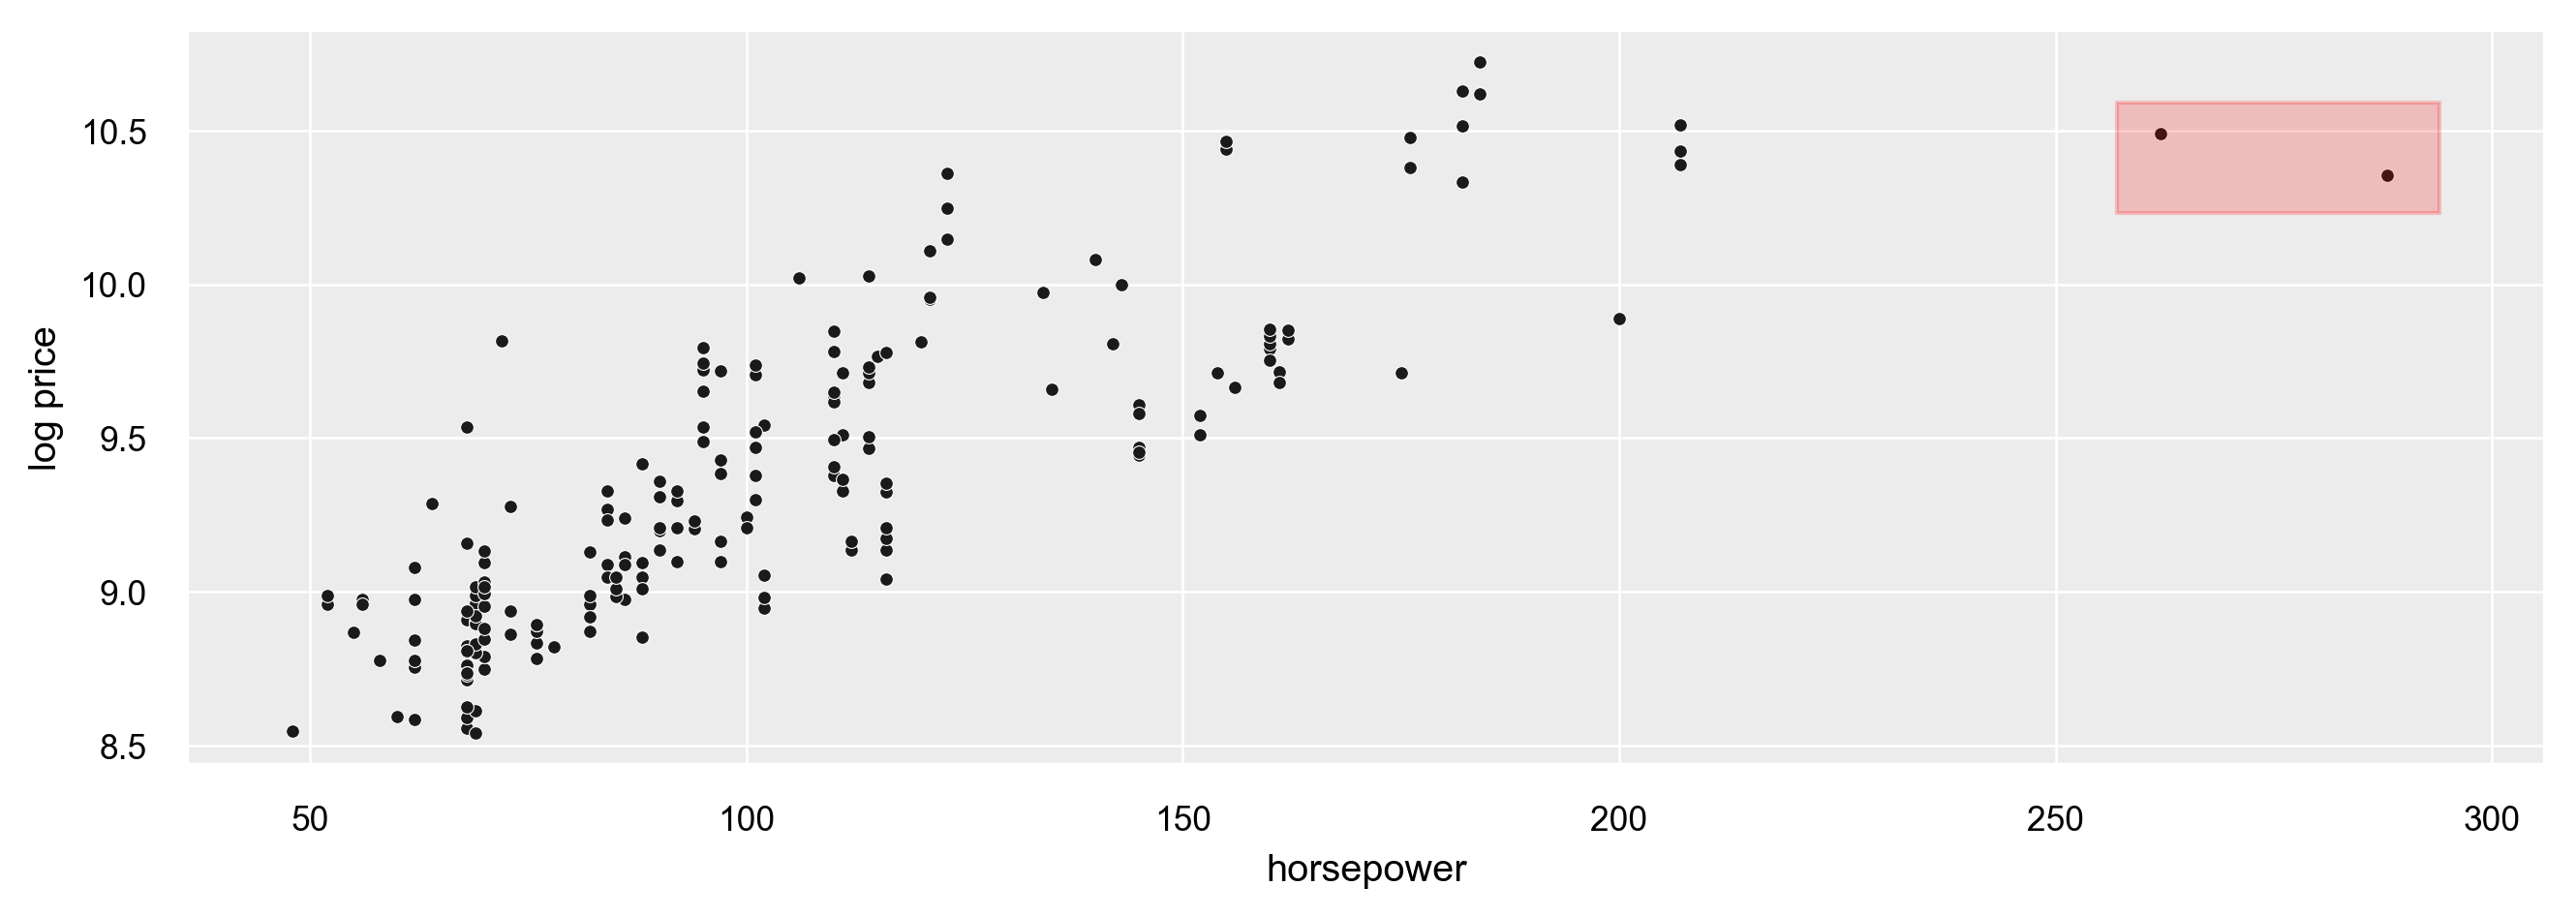

In [57]:
with plt.rc_context(rc = {'figure.dpi': 300, 'axes.labelsize': 9.5, 
                          'xtick.labelsize': 8.5, 'ytick.labelsize': 8.5}): 

    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax_flat = ax.flatten()
    
    sns.scatterplot(ax=ax_flat[0], y=df['log price'], x=df['horsepower'], 
                    s=11, color='k')
    
    ax_flat[0].axvspan(xmin=257, xmax=294, 
                       ymin=0.75, ymax=0.9, 
                       alpha=0.2, color='red')
    
    [axes.set_visible(False) for axes in ax_flat[1:]]
    
    plt.tight_layout(pad=1)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">One can fairly argue that the highlighted observations our model failed to capture well enough were not at all outliers, and, to some extent, I can agree. Nevertheless, we cannot be sure whether those values were representative of a nonlinear relationship (since we don’t have a sufficient number of similar observations) or they were simply unusual. That is why domain knowledge can be absolutely crucial.</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Residuals' distribution</b>:</div></p>

* <div style = "text-align: justify; font-size: 14px">Plot № 5 (e) and plot № 6 (f) should help us identify what distribution our residuals have. If we see that they are far from being normal, we can opt for GLM or use bootstrap to construct confidence intervals. In this case, residuals were close to normality; a bit heavy on the right tail, which was the case because of the two "outliers". Note, if your data has some significant outliers, you are better off working with either quantile regression or robust regression;</div>


* <div style = "text-align: justify; font-size: 14px">Plot № 7 (g): as expected, plotting $Y$ against residuals showed some positive correlation, but it was not too strong;</div>


* <div style = "text-align: justify; font-size: 14px">Finally, plot № 4 (d) should look meaningless: no trends, no heteroskedasticity. This model failed to achieve it – we can clearly see some spikes and non-constant variance. Also, when the summary of our model was printed, the value of Durbin-Watson statistic was low (1.094), suggesting autocorrelation. This was discussed more thoroughly a bit later.</div>

<p><div style = "text-align: justify; font-size: 14px">In addition to visual analysis, we can also perform some tests:</div></p>

In [60]:
round(shapiro(model_1_results['residuals'])[1], 3)

0.494

In [61]:
round(normal_ad(model_1_results['residuals'])[1], 3)

0.247

<p><div style = "text-align: justify; font-size: 14px">According to both tests, we did not have enough evidence to conclude that our residuals were not distributed normally (assuming $α = 0.05$).</div></p>

In [62]:
C = pd.DataFrame(het_breuschpagan(model_1_results['residuals'], model_1.exog),
                 index = ['Lm', 'Lm p-value', 'F', 'F p-value'],
                 columns = ['Value']).round(3)

D = pd.DataFrame(het_white(model_1_results['residuals'], model_1.exog),
                 index = ['Lm', 'Lm p-value', 'F', 'F p-value'],
                 columns = ['Value']).round(3)

In [63]:
multi_table([C, D])

,Value
Lm,45.509
Lm p-value,0.000
F,11.356
F p-value,0.000
,Value
Lm,67.643
Lm p-value,0.000
F,5.786
F p-value,0.000


<p><div style = "text-align: justify; font-size: 14px">According to both tests, we did not have enough evidence to conclude that our residuals were homoskedastic (assuming $α = 0.05$).</div></p>

<p><div style = "text-align: justify; font-size: 14px"><b>Summary</b>:</div></p>

* <div style = "text-align: justify; font-size: 14px">Heteroskedasticity was present;</div>

* <div style = "text-align: justify; font-size: 14px">Autocorrelation was potentially present. Further analysis was needed;</div>

* <div style = "text-align: justify; font-size: 14px">Residuals were approximately normal.</div>

<p><div style = "text-align: justify; font-size: 14px">Since regressors were picked just for the sake of argument, it was not surpirsing that plenty of problems occurred. Nonetheless, it just showed that visual analysis worked as intended.</div></p>

### 2.3 Autocorrelation. Practice

<div style = "text-align: justify; font-size: 14px">Spotting autocorrelation based on the previous plots might be quite challenging. That is why $ACF$ and $PACF$ plots should be drawn as well:</div>

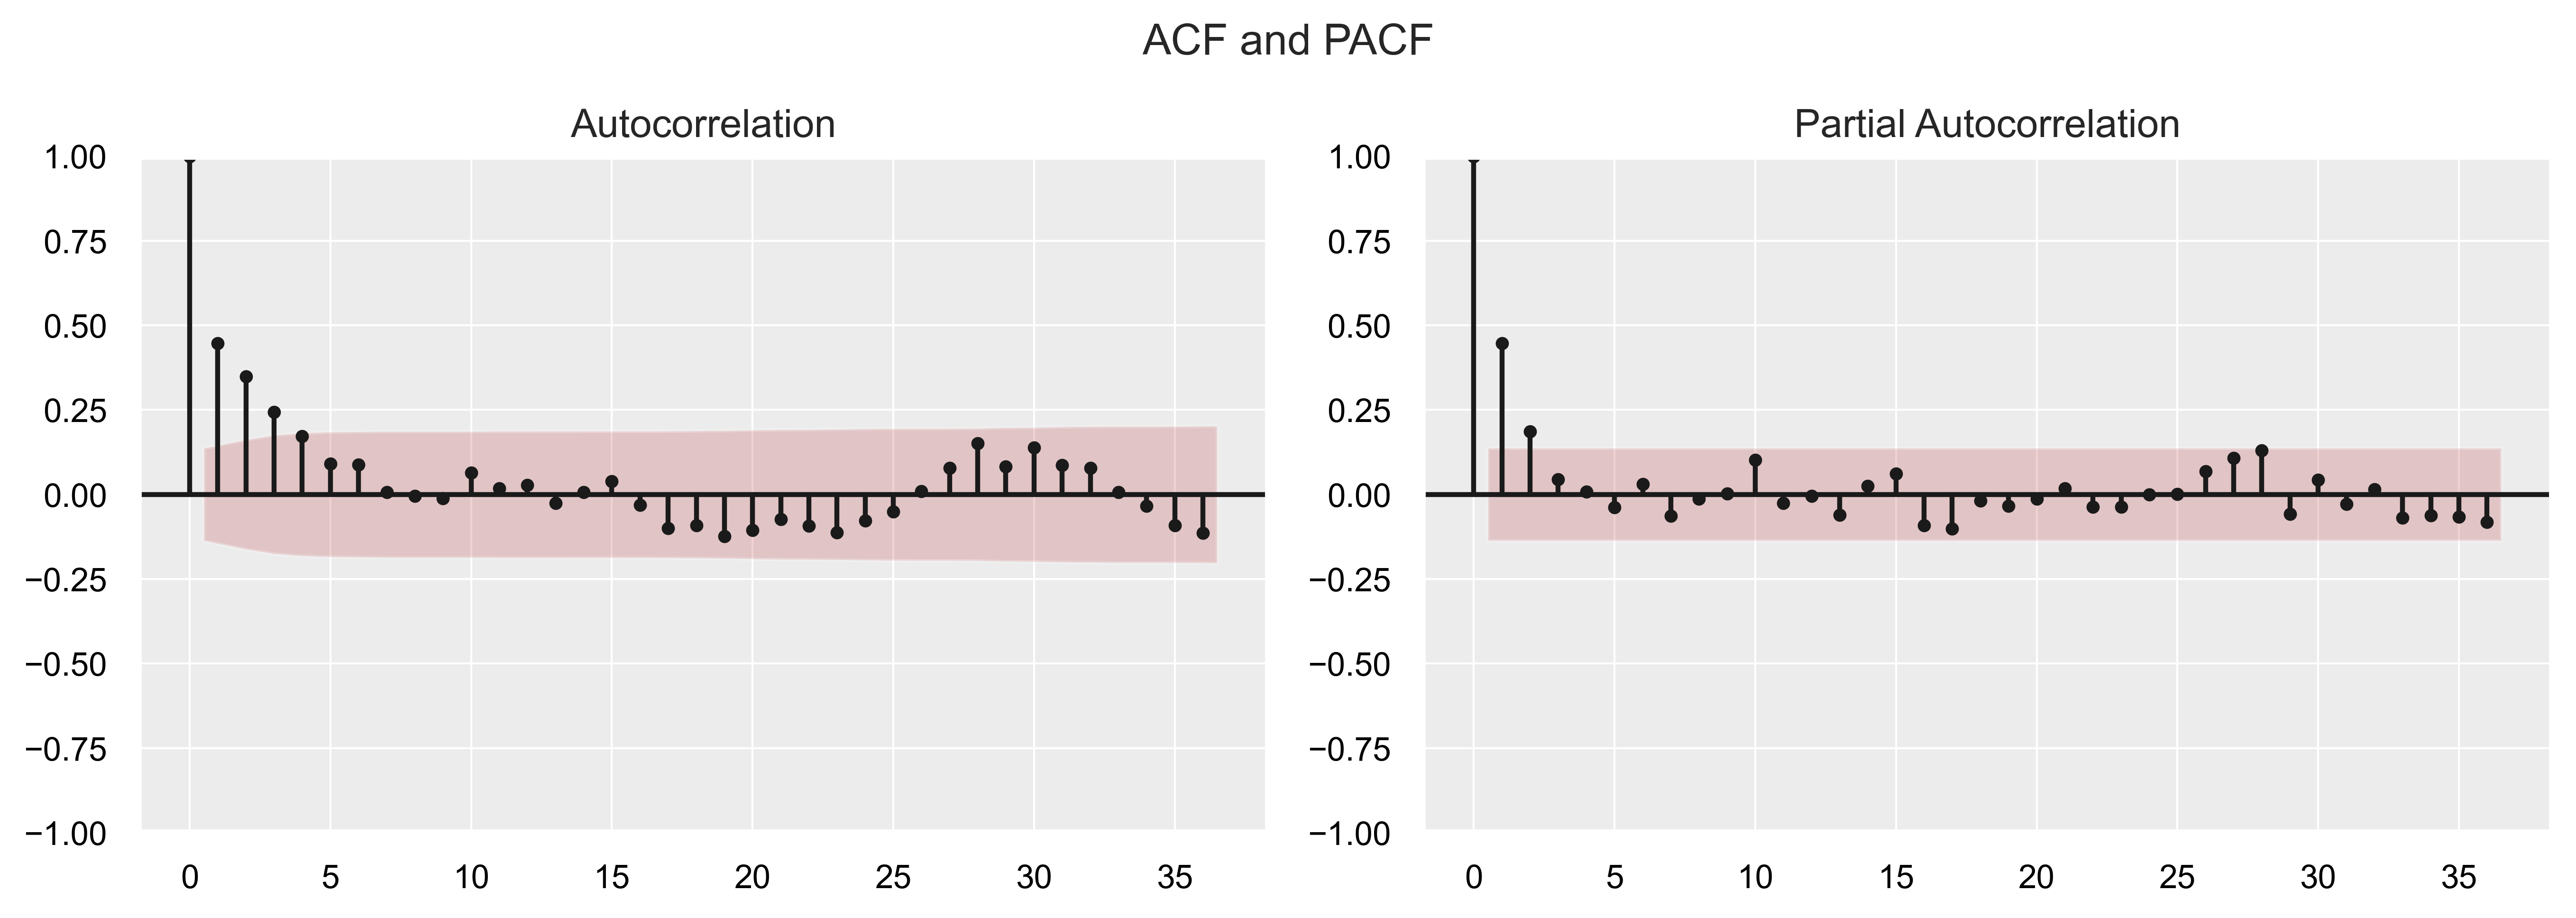

In [65]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}): 

    fig, ax = plt.subplots(2, 2, figsize=(11, 7))
    ax_flat = ax.flatten()

    tsaplots.plot_acf(model_1_results['residuals'], lags=36, ax=ax_flat[0],
                      markerfacecolor='k', markeredgecolor='k', markersize=3,
                      vlines_kwargs={"colors": 'k'})
    
    ax_flat[0].collections[1].set_facecolor('r')
    ax_flat[0].lines[0].set_color('k')
    
    tsaplots.plot_pacf(model_1_results['residuals'], lags=36, ax=ax_flat[1],
                       markerfacecolor='k', markeredgecolor='k', markersize=3,
                       vlines_kwargs={"colors": 'k'})
    
    ax_flat[1].collections[1].set_facecolor('r')
    ax_flat[1].lines[0].set_color('k')

    [axes.set_visible(False) for axes in ax_flat[2:]]
    
    fig.suptitle('ACF and PACF', fontsize=13)
    plt.tight_layout(pad=1)
    plt.show()

<p><div style = "text-align: justify; font-size: 14px">It is evident that there were multiple significant correlation coefficients. Thus, the presence of autocorrelation was confirmed. Based on $PACF$ plot it can be seen that the second coefficient (lag 2) became barely significant. So, $\hat{ε}_{t-1}$ could explain the autocorrelation structure of the residuals well enough. Having such a strong autocorrelation in panel data is a little odd. Lastly, the Ljung-Box test was performed so as to one more time confirm the findings:</div></p>

In [74]:
acorr_ljungbox(model_1_results['residuals'], lags=12, model_df=6, return_df=True)

,lb_stat,lb_pvalue
1,41.533022,NaN
2,66.981226,NaN
3,79.493965,NaN
4,85.748378,NaN
5,87.514859,NaN
6,89.159847,NaN
7,89.169593,3.623763e-21
8,89.172892,4.328650e-20
9,89.200396,3.253067e-19
10,90.088810,1.260783e-18


<p><div style = "text-align: justify; font-size: 14px">When the residuals of your model are highly correlated, it makes sense to opt for regression with $ARIMA$ errors because you will not loose interpretability. To make this example more complete, a model with the same parameters but $ARIMA$ errors was built:</div></p>

```
Series: df$price 
Regression with ARIMA(1,1,1) errors 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ma1  drivewheel_fwd  drivewheel_rwd  aspiration_turbo
      0.5849  -0.9847         -0.0857          0.1233            0.0425
s.e.  0.0745   0.0223          0.0620          0.0736            0.0318
      horsepower  wheelbase
          0.0062     0.0207
s.e.      0.0005     0.0034

sigma^2 estimated as 0.03313:  log likelihood=60.54
AIC=-105.08   AICc=-104.34   BIC=-78.54
```

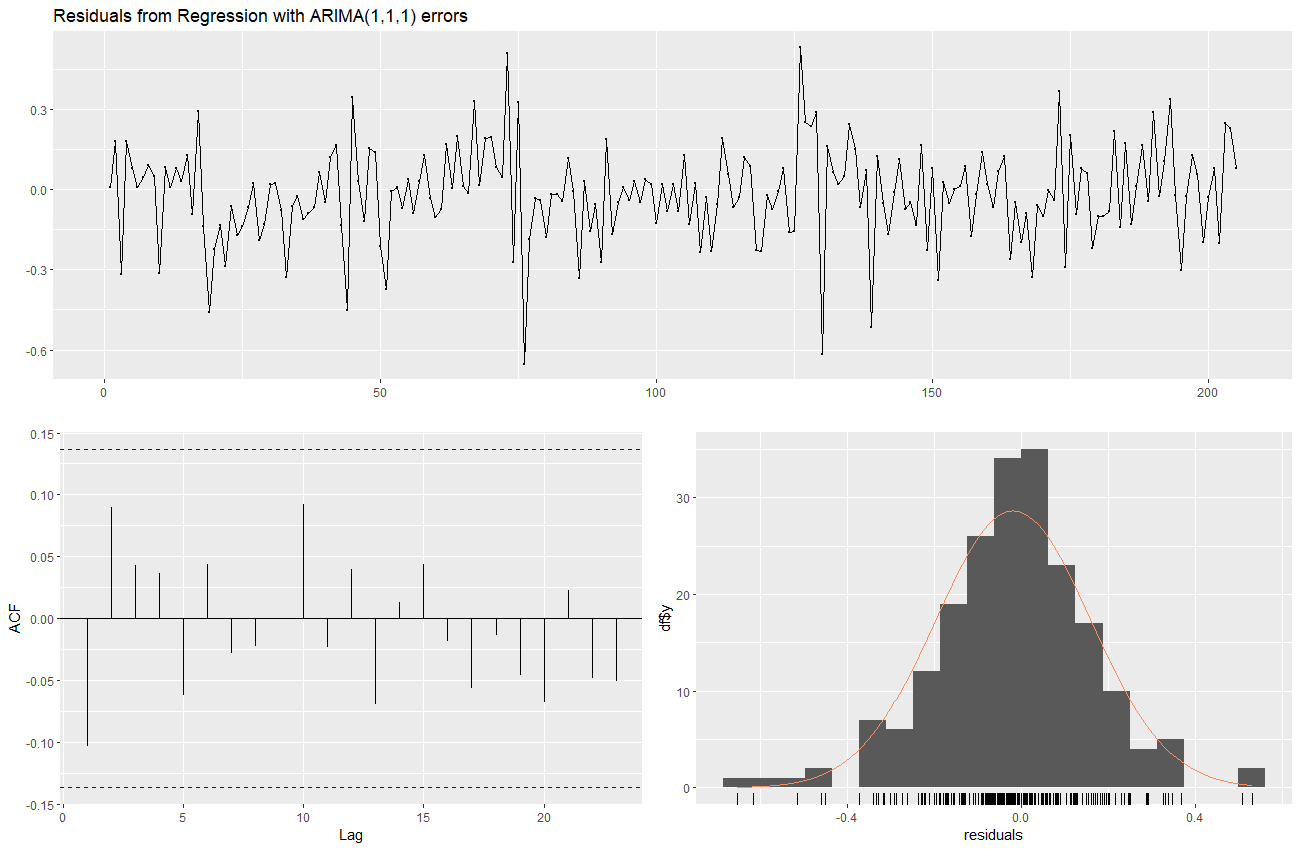

<p><div style = "text-align: justify; font-size: 14px">First, the problem of autocorrelation was fully addressed. Second, it is important to mention that the coefficients of our parameters did not change much.</div></p>

## 3. Some notes on how to interpret coefficients of dummy variables <a class="anchor" id = "III_3"></a>

In [68]:
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     193.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.86e-74
Time:                        19:47:53   Log-Likelihood:                 31.598
No. Observations:                 205   AIC:                            -51.20
Df Residuals:                     199   BIC:                            -31.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8585      0.289  

<p><div style = "text-align: justify; font-size: 14px">Since significance of dummy variables is interpreted relative to the excluded category, we need additionally test whether included categorical variables are significant at all. To do so, we can use $ANOVA$.</div></p>

<p><div style = "text-align: justify; font-size: 14px"> <b>Some insightful examples</b>: [<a href="https://stats.stackexchange.com/questions/160026/why-does-an-insignificant-regressor-become-significant-if-i-add-some-significant">1</a>, <a href="https://towardsdatascience.com/statistics-in-python-using-anova-for-feature-selection-b4dc876ef4f0">2</a>].</div></p>

In [70]:
df['log_price'] = np.log(df['price'])

reg_model_drivewheel = ols('log_price' + '~' + 'drivewheel', data = df).fit()

sm.stats.anova_lm(reg_model_drivewheel)[0:1]

,df,sum_sq,mean_sq,F,PR(>F)
drivewheel,2.0,24.512115,12.256058,90.795262,7.410259e-29


In [71]:
reg_model_aspiration = ols('log_price' + '~' + 'aspiration', data = df).fit()

sm.stats.anova_lm(reg_model_aspiration)[0:1]

,df,sum_sq,mean_sq,F,PR(>F)
aspiration,1.0,3.431646,3.431646,14.408671,0.000194


<p><div style = "text-align: justify; font-size: 14px">In this model, both <span style="color:#0049d1">drivewheel</span> and <span style="color:#0049d1">aspiration</span> were significant (assuming $α = 0.05$).</div></p>